In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

In [296]:
df = pd.read_csv("../k2scoc/results/tables/full_table.csv")


hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
df = df[hasflares  | wassearched]

In [297]:
pleiades = pd.read_csv("rebull2016pleiadesrot.tsv",  delimiter='\t',skiprows=68)
pleiadesflares = df[df.cluster=="pleiades"].merge(pleiades[["EPIC","Prot"]], how="left", on="EPIC")
pleiadesflares = pleiadesflares.rename(index=str, columns={"Prot":"prot"})
pleiadesflares[pleiadesflares.real==1].shape


(1606, 25)

In [298]:
hyades = pd.read_csv("rotation/hyades_douglas2019_r.csv", header=None, names=np.arange(33))
hyades = hyades[[3,16,6,17,18,19,20,21,22,26]]
hyades = hyades.rename(index=str, columns={3:"EPIC",6:"3",16:"rotflag",
                                           17:"2",18:"P",19:"H",20:"D",
                                           21:"K",22:"R",26:"mem"})


hyades = hyades.dropna(subset=["EPIC"])
hyades = hyades.dropna(subset=["rotflag"])


hyades.EPIC = hyades.EPIC.apply(lambda x: x.replace(' ',"")[:9]).astype(int)
hyades.rotflag = hyades.rotflag.str.strip(" ")

hyades["prot"] = hyades.apply(lambda x: x[x.rotflag], axis=1)
hyades.head()

hyadesflares = df[df.cluster=="hyades"]
hyadesflares = hyadesflares.merge(hyades, how="left", on="EPIC")


In [299]:
praesepe = pd.read_csv("rotation/praesepe_douglas2019_r.csv", header=None, names=np.arange(18))
praesepe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,130.815583,20.333611,NaN,212004731.0,3.96,2,3.96,2,1.716940,0.001921,-2.82,4.55,NaN,11.943,0.703,6196.83,6.614383e+17,NYYNN
1,130.089167,19.181694,NaN,211930461.0,14.59,2,14.59,2,-0.000313,0.019007,-11.02,7.48,NaN,13.977,1.754,4019.60,6.612111e+17,YYYNN
2,130.281097,21.915726,2MASS J08410747+2154567,212094548.0,6.60,2,6.60,2,-0.075211,0.090267,NaN,NaN,0.87,18.410,3.251,3097.71,6.651784e+17,NYY-Y
3,129.979355,20.065041,2MASS J08395507+2003542,211988287.0,3.29,2,3.29,2,0.110128,0.001432,-1.14,0.26,NaN,9.991,0.645,6395.48,6.643274e+17,YYYYY
4,130.002548,19.806503,2MASS J08400063+1948235,211971871.0,2.99,K,2.99,K,0.097828,0.002062,NaN,NaN,NaN,10.162,0.676,6289.11,6.613118e+17,YYY-Y


In [300]:
praesepe = praesepe[[3,6]]
praesepe = praesepe.rename(index=str, columns={3:"EPIC",6:"prot"})


praesepe = praesepe.dropna(subset=["EPIC"])
praesepe = praesepe.dropna(subset=["prot"])

praesepe.EPIC = praesepe.EPIC.astype(int)

praesepeflares = df[df.cluster=="praesepe"]
praesepeflares = praesepeflares.merge(praesepe, how="left", on="EPIC")

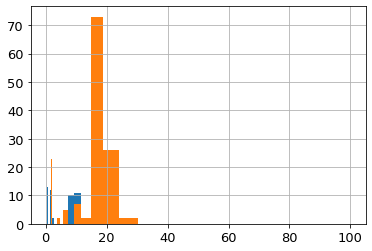

In [301]:
bins = np.logspace(-1,2,30)
hyadesflares[(hyadesflares.Teff_median>3500) & (hyadesflares.Teff_median< 3750)].prot.hist(bins=bins)

praesepeflares[(praesepeflares.Teff_median>3500) & (praesepeflares.Teff_median< 3750)].prot.hist(bins=bins)

In [302]:
bins_T = pd.cut(hyadesflares["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"])

Thyades = hyadesflares.groupby(bins_T)

bins_T = pd.cut(praesepeflares["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"])

Tpraesepe = praesepeflares.groupby(bins_T)

bins_T = pd.cut(pleiadesflares["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"])

Tpleiades = pleiadesflares.groupby(bins_T)

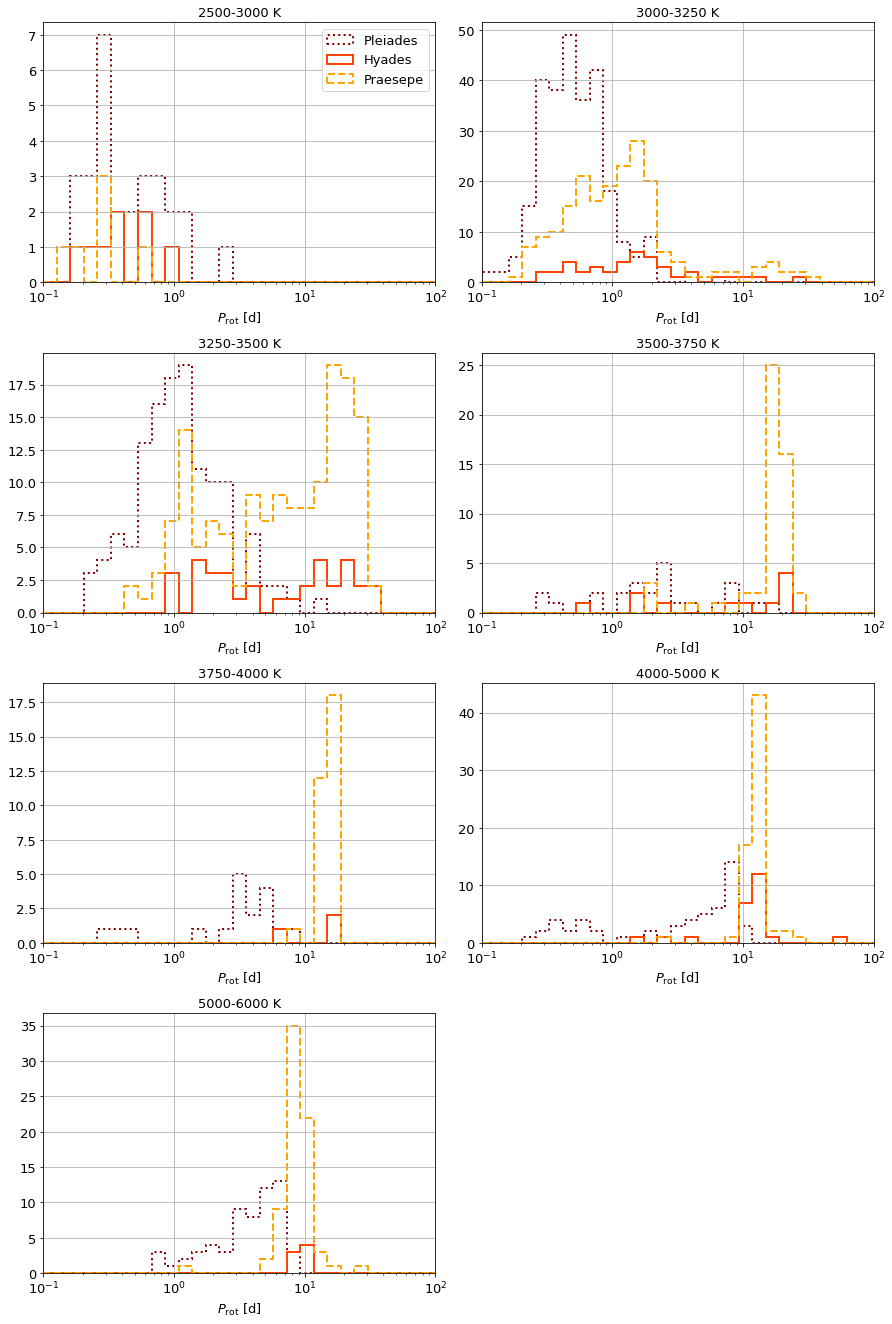

In [303]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5), squeeze=True)
axes = [l for x in axes for l in x]
k=0
for bint, g in Tpleiades:
    g = g.drop_duplicates(subset=["EPIC","prot"])
    g.prot.hist(bins=bins, ax=axes[k],edgecolor="maroon", linestyle="dotted",
                histtype="step",linewidth=2,label="Pleiades")#,density=True)
    k += 1
k=0
for bint, g in Thyades:
    g = g.drop_duplicates(subset=["EPIC","prot"])
    g.prot.hist(bins=bins, ax=axes[k],edgecolor="orangered",
                histtype="step",linewidth=2,label="Hyades")#,density=True)
    k += 1
k=0
for bint, g in Tpraesepe:
    g = g.drop_duplicates(subset=["EPIC","prot"])
    g.prot.hist(bins=bins, ax=axes[k],edgecolor="orange",
                histtype="step",linewidth=2, linestyle="dashed",
                label="Praesepe")#,density=True)
    
    axes[k].set_title(bint + " K")
    axes[k].set_xscale("log")
    axes[k].set_xlim(.1,100)
    axes[k].set_xlabel(r"$P_\mathrm{rot}$ [d]")
    k += 1
axes[-1].axis('off')
axes[0].legend()
plt.tight_layout()
plt.savefig(f"{paperdir}pics/rotation/SpT_wise_rotation.png", dpi=300)

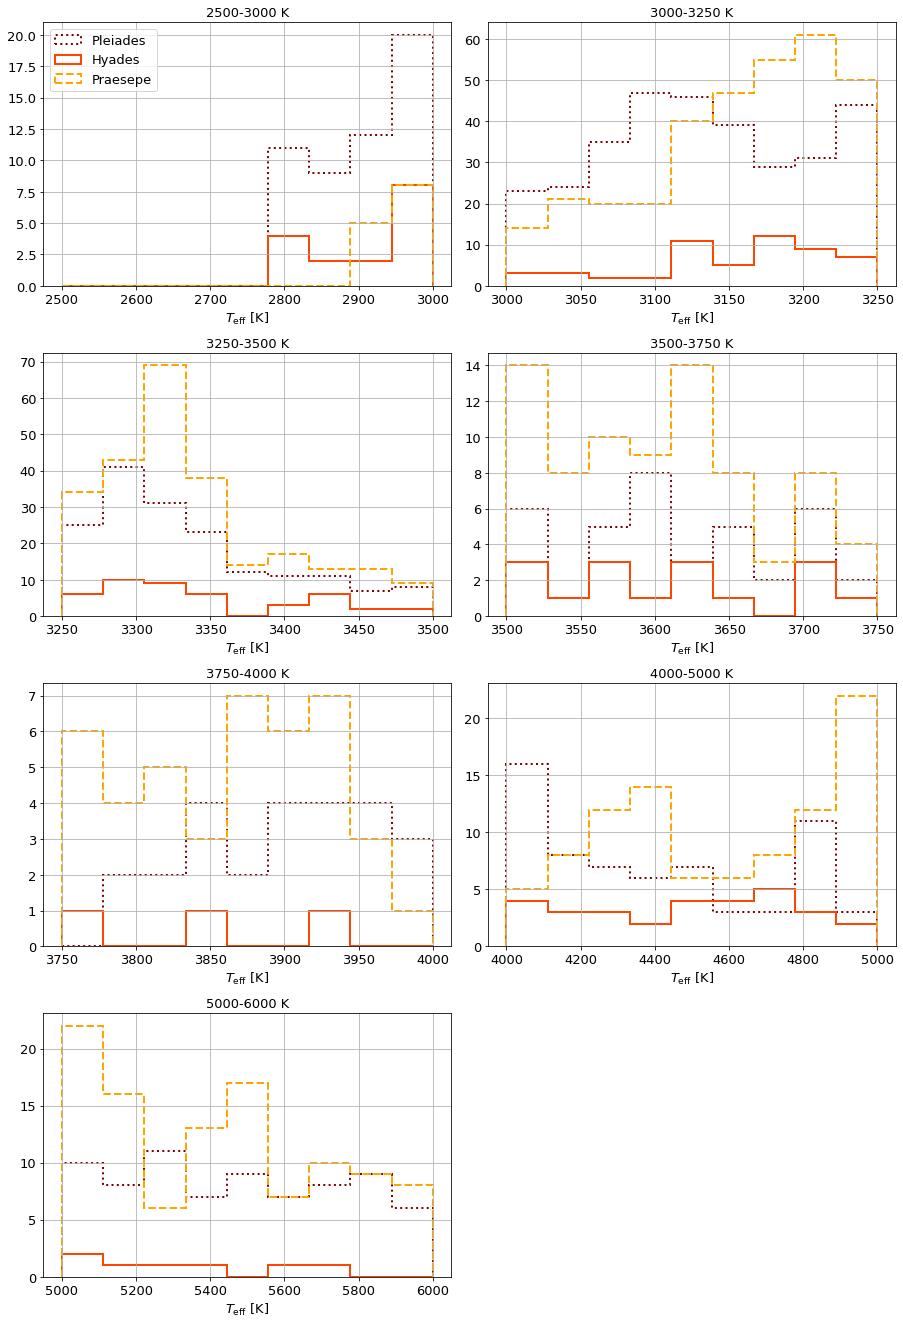

In [294]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5), squeeze=True)
axes = [l for x in axes for l in x]
k=0
for bint, g in Tpleiades:
    g = g.drop_duplicates(subset=["EPIC"])
    bins = np.linspace(float(bint.split("-")[0]),float(bint.split("-")[1]),10)
    g.Teff_median.hist(bins=bins, ax=axes[k],edgecolor="maroon", linestyle="dotted",
                histtype="step",linewidth=2,label="Pleiades")#,density=True)
    k += 1
k=0
for bint, g in Thyades:
    g = g.drop_duplicates(subset=["EPIC"])
    bins = np.linspace(float(bint.split("-")[0]),float(bint.split("-")[1]),10)
    g.Teff_median.hist(bins=bins, ax=axes[k],edgecolor="orangered",
                histtype="step",linewidth=2,label="Hyades")#,density=True)
    k += 1
k=0
for bint, g in Tpraesepe:
    g = g.drop_duplicates(subset=["EPIC"])
    bins = np.linspace(float(bint.split("-")[0]),float(bint.split("-")[1]),10)
    g.Teff_median.hist(bins=bins, ax=axes[k],edgecolor="orange",
                histtype="step",linewidth=2, linestyle="dashed",
                label="Praesepe")#,density=True)
    
    axes[k].set_title(bint + " K")
    #axes[k].set_xscale("log")
    #axes[k].set_xlim(.1,100)
    axes[k].set_xlabel(r"$T_\mathrm{eff}$ [K]")
    k += 1
axes[-1].axis('off')
axes[0].legend(loc=2)
plt.tight_layout()
#plt.savefig(f"{paperdir}pics/rotation/SpT_wise_rotation.png", dpi=300)

In [211]:
hyadesflares[(hyadesflares.Teff_median>3500) & (hyadesflares.Teff_median< 3750)].sort_values("prot")[["prot","EPIC","ed_rec"]].drop_duplicates(subset=["EPIC","prot"])

,prot,EPIC,ed_rec
365,0.58,210923016,51.768918
315,1.54,210721261,855.055719
477,1.55,247122957,33.710739
45,2.50,247592661,484.815992
84,8.69,210408563,2.743465
329,10.97,210741091,73.906617
410,14.94,246806983,111.662962
188,20.73,210941195,18.865482
206,21.02,211036776,6.978144
501,21.47,247164626,25.797001


In [270]:
rotfrac = {}
for cluster, d,binned in [("Praesepe",praesepeflares,Tpraesepe),
                          ("Hyades",hyadesflares, Thyades),
                          ("Pleiades",pleiadesflares,Tpleiades)]:
    d = d.drop_duplicates(subset=["EPIC","prot"])
    print(d[d.prot.isnull()].shape[0],d[~d.prot.isnull()].shape[0],
          d[d.prot.isnull()].shape[0]+d[~d.prot.isnull()].shape[0], d.shape[0])
    rotfrac[cluster] = {}
    for tbin, g in binned:
        rotfrac[cluster][tbin] = {"cluster":cluster,
                                    "n_s":g.shape[0],
                                  "P":g[~g.prot.isnull()].shape[0],
                                  "f":g[~g.prot.isnull()].shape[0]/g.shape[0]
                                  } 
        print(tbin, g[g.prot.isnull()].shape[0],g[~g.prot.isnull()].shape[0],)

357 607 964 964
2500-3000 8 9
3000-3250 214 329
3250-3500 233 481
3500-3750 77 140
3750-4000 40 58
4000-5000 45 133
5000-6000 100 152
43 128 171 171
2500-3000 18 24
3000-3250 33 158
3250-3500 36 192
3500-3750 36 75
3750-4000 0 13
4000-5000 31 61
5000-6000 0 29
156 605 761 761
2500-3000 23 36
3000-3250 103 749
3250-3500 77 697
3500-3750 25 157
3750-4000 26 117
4000-5000 43 238
5000-6000 23 140


In [271]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in rotfrac.items() for innerKey, values in innerDict.items()}

rotf = pd.DataFrame(reform).T


In [272]:
rotf.T

Praesepe                                                              \
        2500-3000 3000-3250 3250-3500 3500-3750 3750-4000 4000-5000 5000-6000   
cluster  Praesepe  Praesepe  Praesepe  Praesepe  Praesepe  Praesepe  Praesepe   
n_s            17       543       714       217        98       178       252   
P               9       329       481       140        58       133       152   
f        0.529412  0.605893  0.673669  0.645161  0.591837  0.747191  0.603175   

           Hyades                      ...                                \
        2500-3000 3000-3250 3250-3500  ... 3750-4000 4000-5000 5000-6000   
cluster    Hyades    Hyades    Hyades  ...    Hyades    Hyades    Hyades   
n_s            42       191       228  ...        13        92        29   
P              24       158       192  ...        13        61        29   
f        0.571429  0.827225  0.842105  ...         1  0.663043         1   

         Pleiades                                                              
        2500-3000 3000-3250 3250-3500 3500-3750 3750-4000 4000-5000 5000-6000  
cluster  Pleiades  Pleiades  Pleiades  Pleiades  Pleiades  Pleiades  Pleiades  
n_s            59       852       774       182       143       281       163  
P              36       749       697       157       117       238       140  
f        0.610169  0.879108  0.900517  0.862637  0.818182  0.846975  0.858896  

[4 rows x 21 columns]

In [276]:
df_pivot = rotf.reset_index()
df_pivot = df_pivot.rename(index=str, columns={"level_1":r"$T_\mathrm{eff}$ [K]"})
df_pivot = df_pivot.pivot(index=r"$T_\mathrm{eff}$ [K]", columns='cluster', values=["f"])
#df_pivot = df_pivot.rename(index=str, columns={"n_s":r"$n_s$", "P": r"$n_P$"})
df_pivot = df_pivot.applymap(lambda x: f"{x:.2f}" )
df_pivot

f                  
cluster              Hyades Pleiades Praesepe
$T_\mathrm{eff}$ [K]                         
2500-3000              0.57     0.61     0.53
3000-3250              0.83     0.88     0.61
3250-3500              0.84     0.90     0.67
3500-3750              0.68     0.86     0.65
3750-4000              1.00     0.82     0.59
4000-5000              0.66     0.85     0.75
5000-6000              1.00     0.86     0.60

In [285]:

nc = 'c' * (df_pivot.shape[1])
stri = df_pivot.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")
stri = stri.replace("{}","")
stri = stri.replace(r" & \multicolumn{3}{l}{f} \\","")

stri = stri.replace("\\bottomrule","\hline\n" )
with open(f"{paperdir}tables/searched_with_rotation.tex", "w") as f:
    f.write(stri)

In [286]:
print(stri)

\begin{tabular}{lcccr}
\hline

cluster & Hyades & Pleiades & Praesepe \\
$T_\mathrm{eff}$ [K] &        &          &          \\
\hline
2500-3000            &   0.57 &     0.61 &     0.53 \\
3000-3250            &   0.83 &     0.88 &     0.61 \\
3250-3500            &   0.84 &     0.90 &     0.67 \\
3500-3750            &   0.68 &     0.86 &     0.65 \\
3750-4000            &   1.00 &     0.82 &     0.59 \\
4000-5000            &   0.66 &     0.85 &     0.75 \\
5000-6000            &   1.00 &     0.86 &     0.60 \\
\hline

\end{tabular}

